# Detector Hits

Demonstrate the total number of hits in the IceCube detector after implementaing neutrino oscillations. Data is read in from `final_data.fits` and the signal is scaled by the progenitor distance (1-30 kpc).

In [32]:
from astropy import units as u
from astropy.table import Table

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

from asteria import config, source, detector
from asteria.neutrino import Flavor

mpl.rc('font', size=18)

## Prepare Iterables

Define the range of neutrino energies (`E_nu`) to simulate and the times (`time`) and distances (`dist`) at which to perform the simulation. 
The progenitor distance is set to 1 kpc.

In [2]:
E_min = 0.1; E_max = 100.1; dE = 0.1;
Enu = np.arange(E_min, E_max, dE) * u.MeV

t_min = -1; t_max = 15; dt = 0.0001;
time = np.arange(t_min, t_max, dt) * u.s

In [3]:
dr = 2933.72
dr_er = 85.8662

icecube_dt = 2e-3 #s
deadtime = 0.25e-3
dc_rel_eff = 1.35

## Load Configuration

This will load the source configuration from a file.

For this to work, either the user needs to have done one of two things:
1. Run `python setup.py install` in the ASTERIA directory.
2. Run `python setup.py develop` and set the environment variable `ASTERIA` to point to the git source checkout.

If these were not done, the initialization will fail because the paths will not be correctly resolved.

In [4]:
conf = config.load_config('../../data/config/test-Copy1.yaml')
ccsn = source.initialize(conf)
ic86 = detector.initialize(conf)

## Define Helper Functions

- `hits` Scale the original signal `signal` calculated for a progenitor at 1 kpc by the distance `dist` of the new progenitor, and use the new signal to generate  and return detector hits for the given progenitor.

- `rebin` Reshape the independent variable `var` with resolution `old_binning` and dependent variable `data` (assumed to be numpy array) and return new arrays `var` and `data` with resolution `new_binning`.


In [5]:
def hits(signal, dist):
    new_signal = signal / dist**2
    eps_i3 = 0.87 / (1+deadtime*np.sum(new_signal, axis=0)/icecube_dt)
    eps_dc = 0.87 / (1+deadtime*np.sum(new_signal, axis=0)*dc_rel_eff/icecube_dt)
    hits = ic86.detector_hits(abs(new_signal), eps_i3, eps_dc)
    return hits

In [6]:
def rebin(var, data, old_binning, new_binning):
    step = int(new_binning/old_binning)
    new_size = int(data.size / step)
    
    rebinned_data = np.sum(np.split( data, new_size ), axis=1)
    rebinned_var  = var.value[int(0.5 * step)::step]   
    
    return rebinned_var, rebinned_data

## Read Data from `final_data.fits`

In [7]:
table = Table.read('final_data.fits')

In [8]:
sig = np.asarray([table['unmixed nu_e sig'], table['unmixed nu_e_bar sig'], table['unmixed nu_x sig'], table['unmixed nu_x_bar sig']])
sig_norm = np.asarray([table['normal nu_e sig'], table['normal nu_e_bar sig'], table['normal nu_x sig'], table['normal nu_x_bar sig']])
sig_inv = np.asarray([table['inverted nu_e sig'], table['inverted nu_e_bar sig'], table['inverted nu_x sig'], table['inverted nu_x_bar sig']])

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


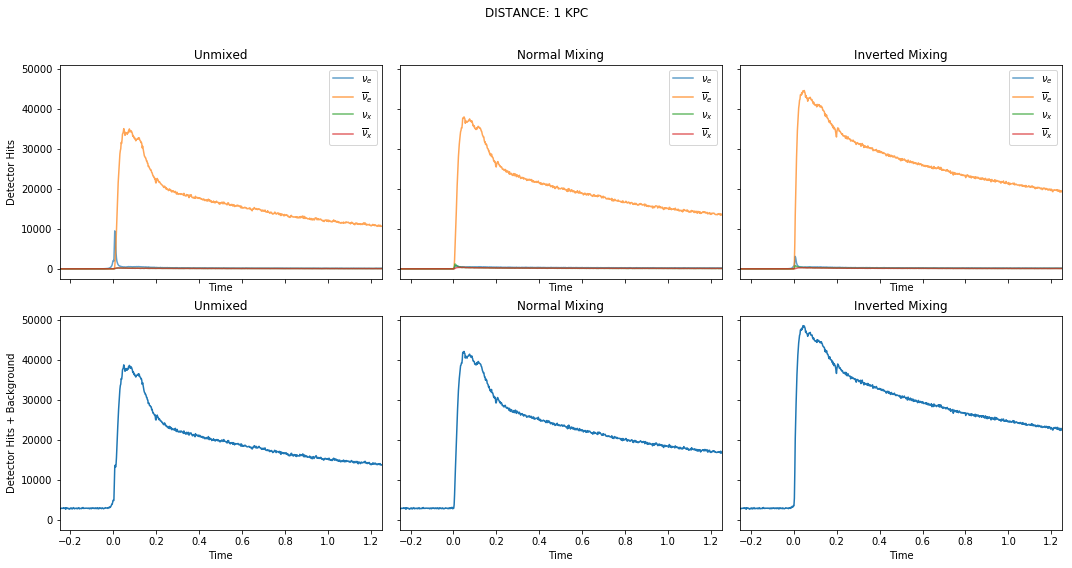

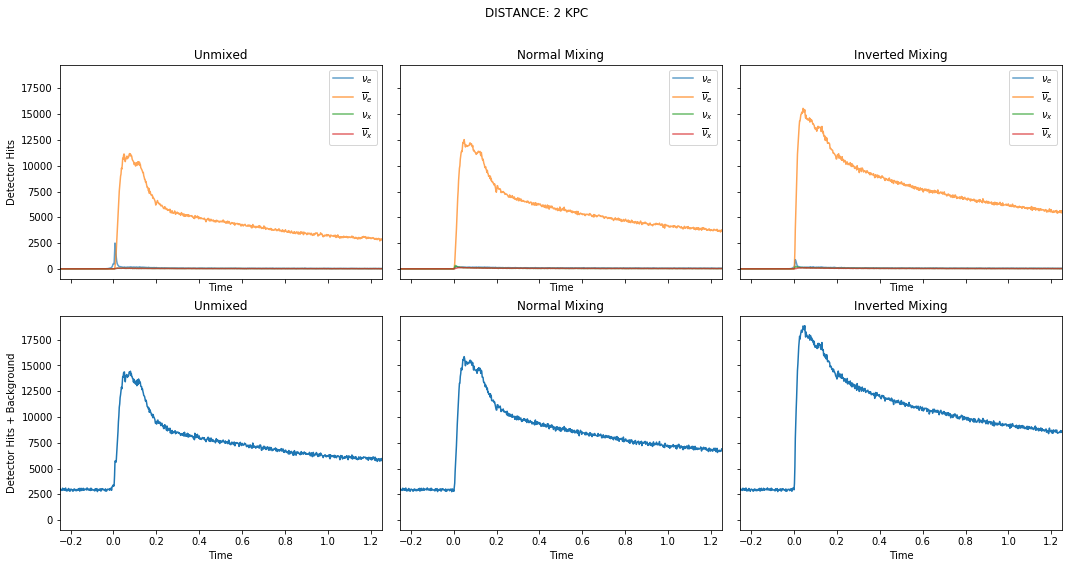

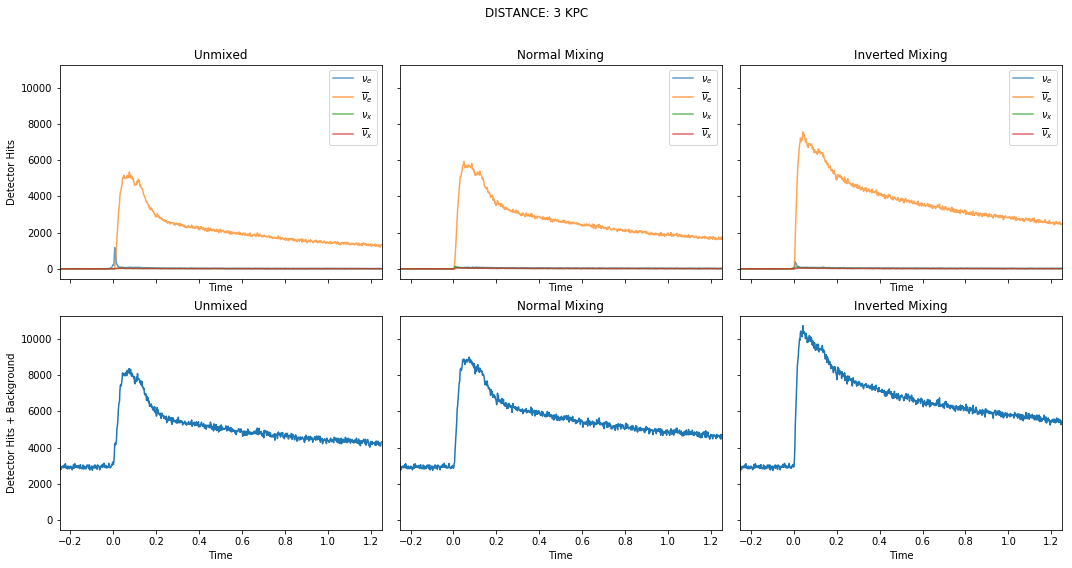

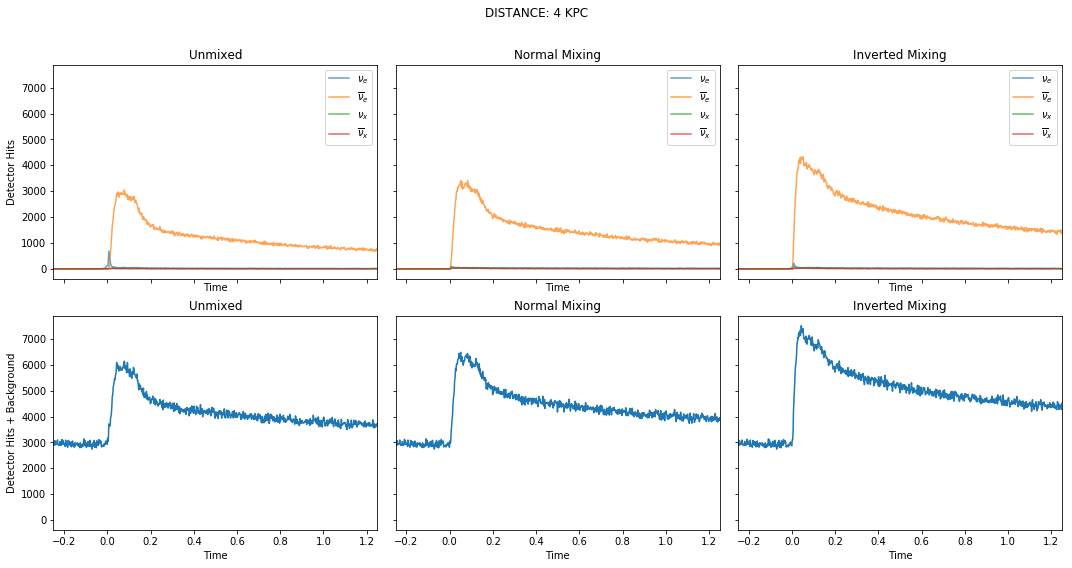

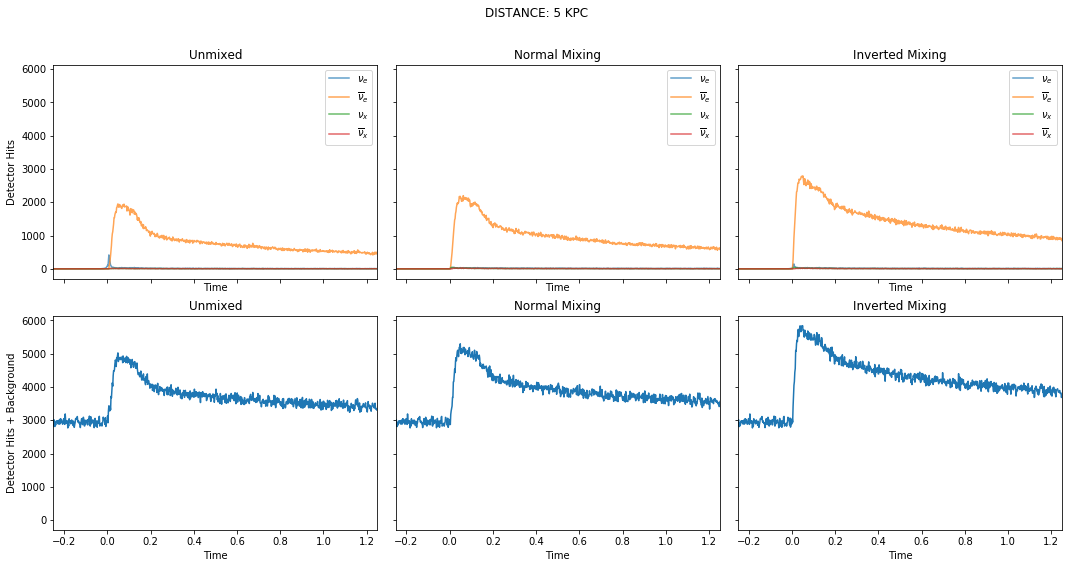

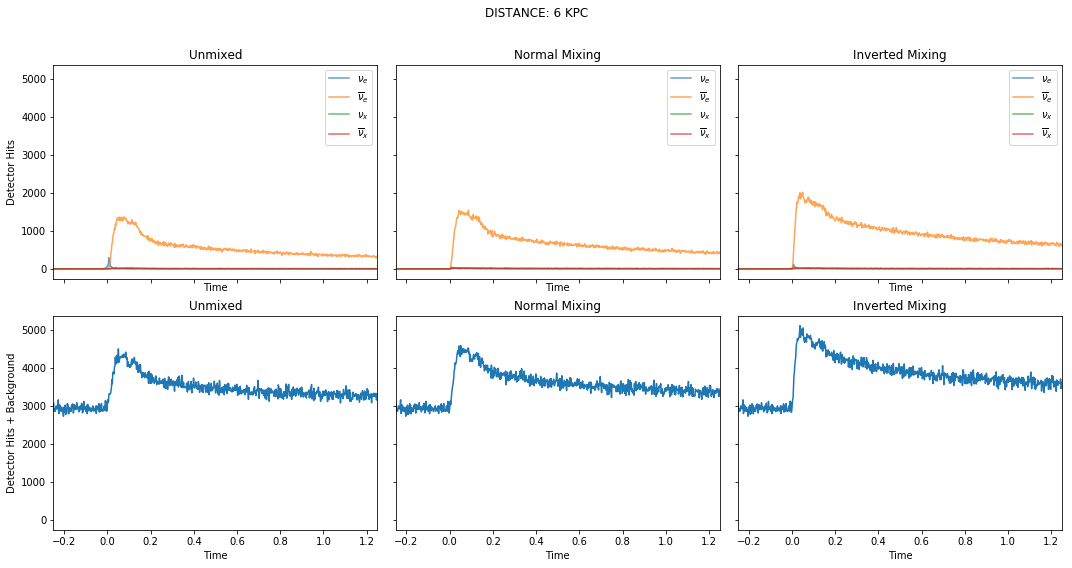

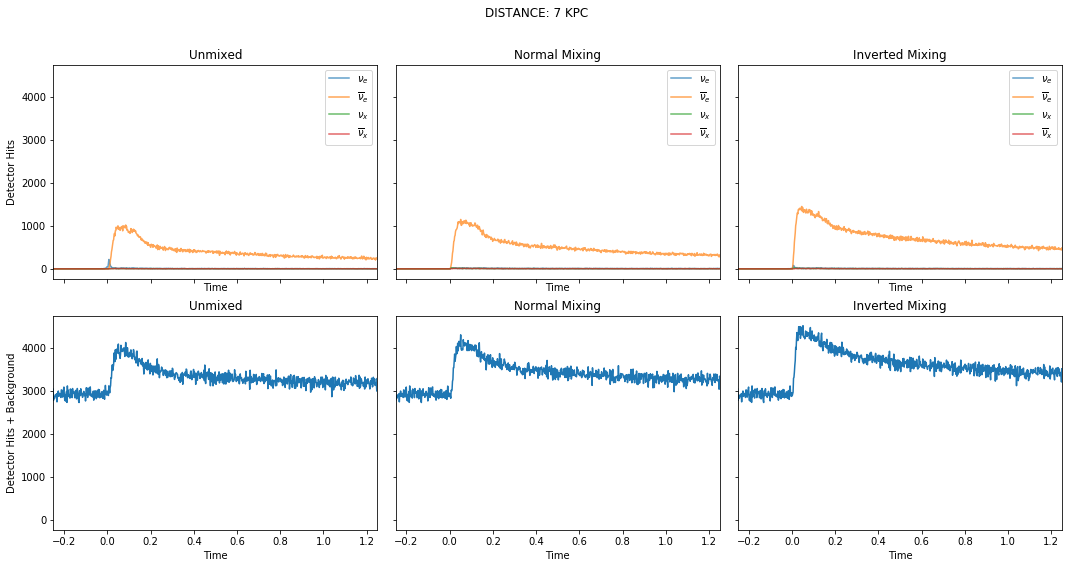

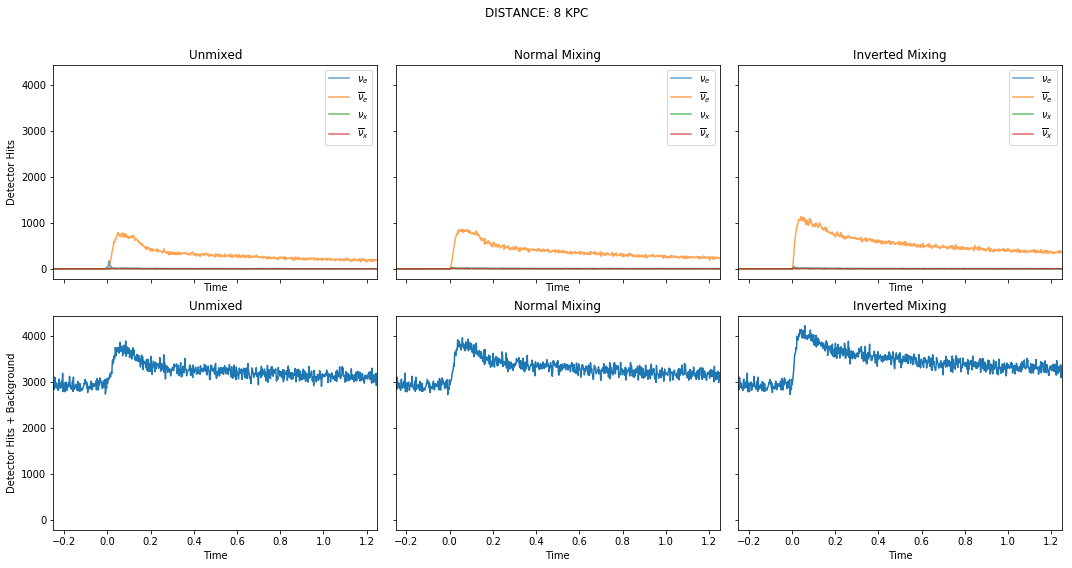

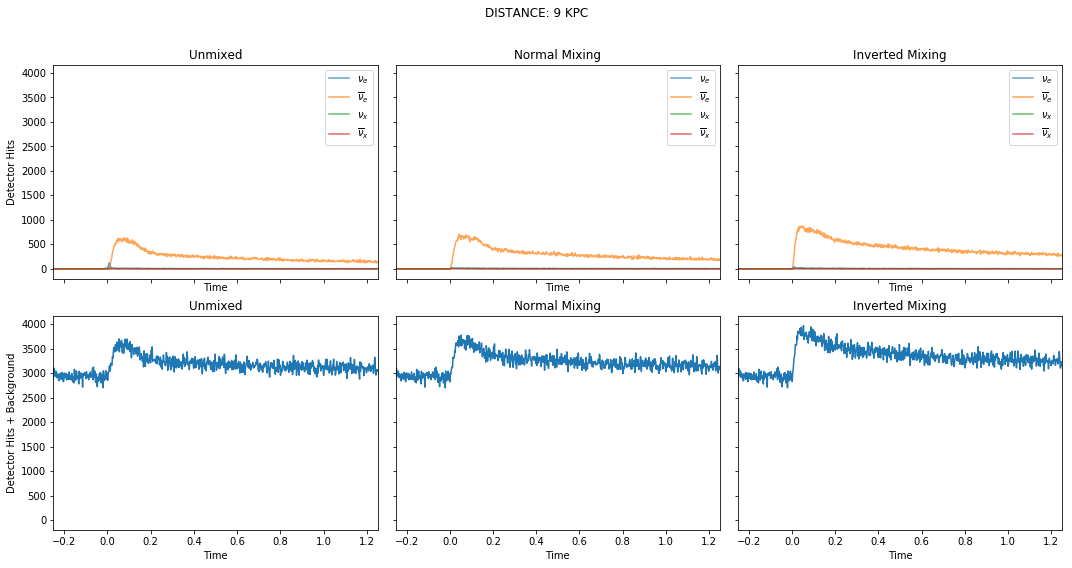

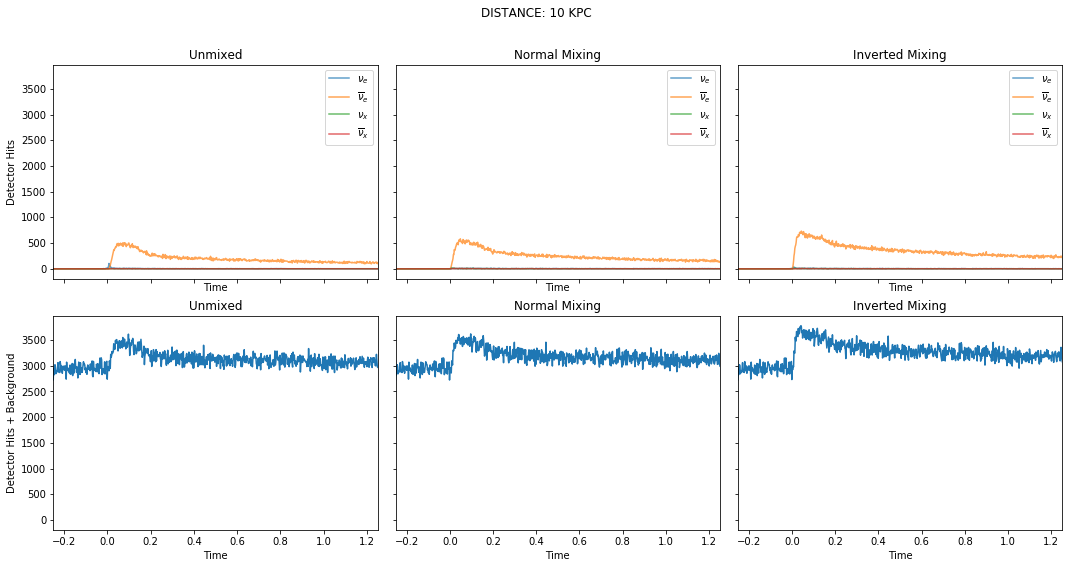

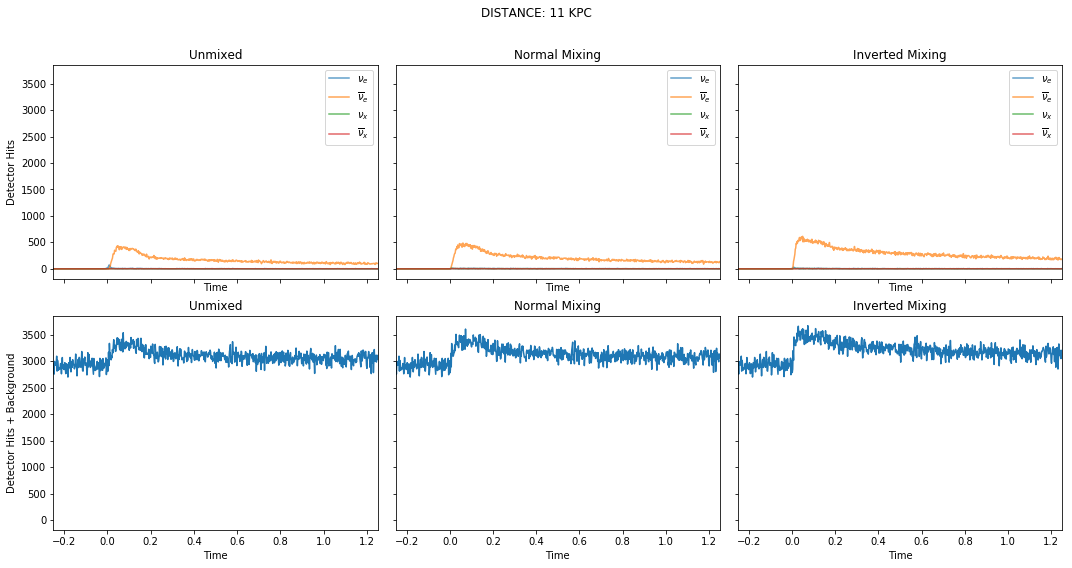

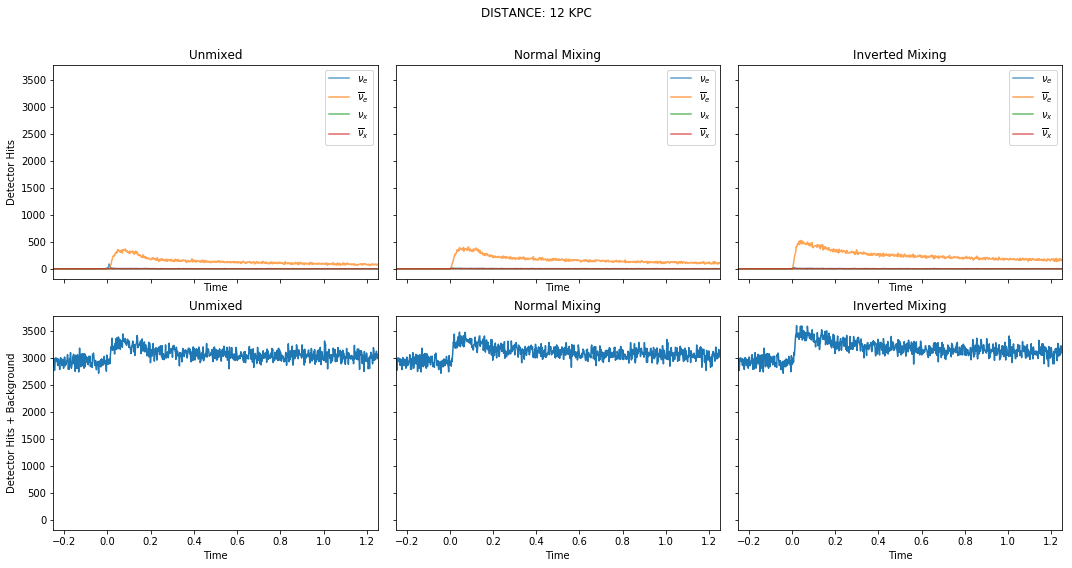

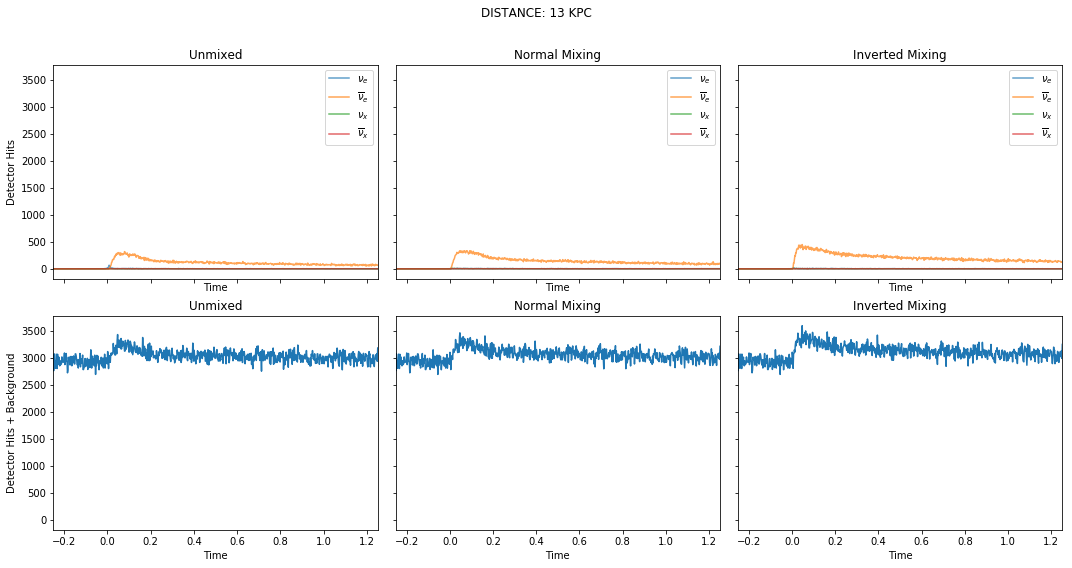

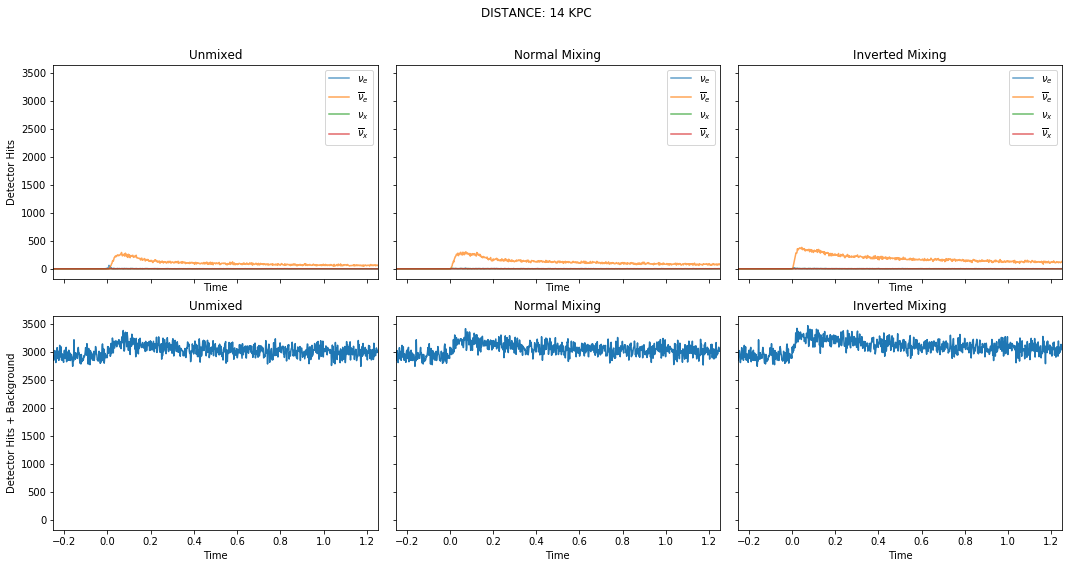

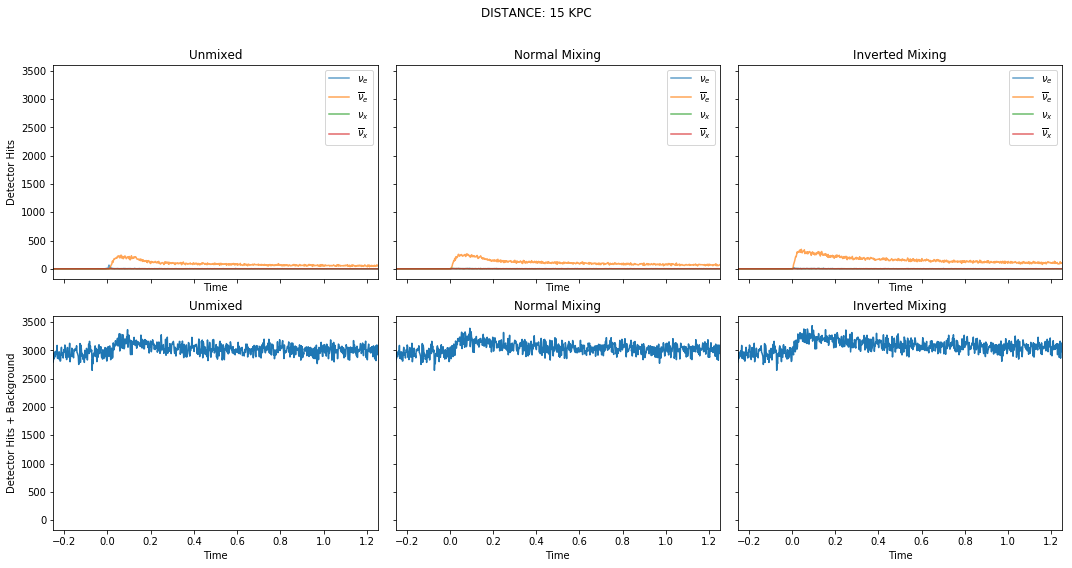

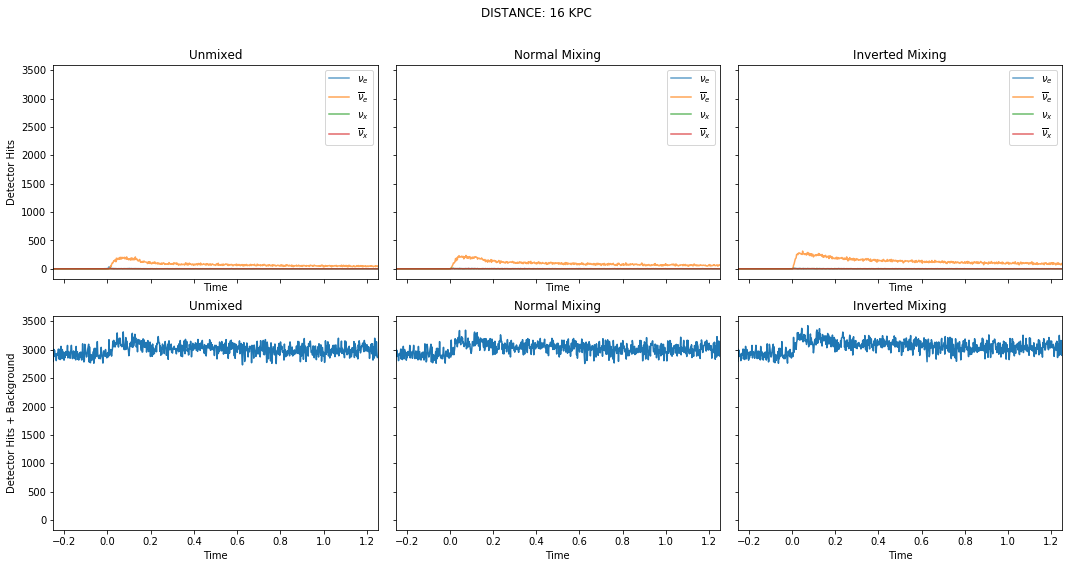

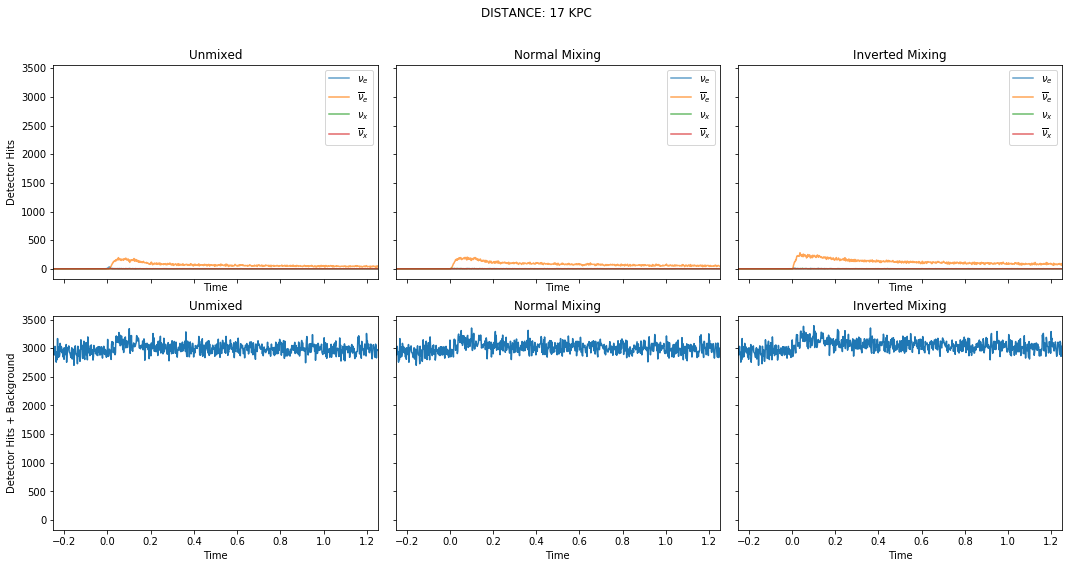

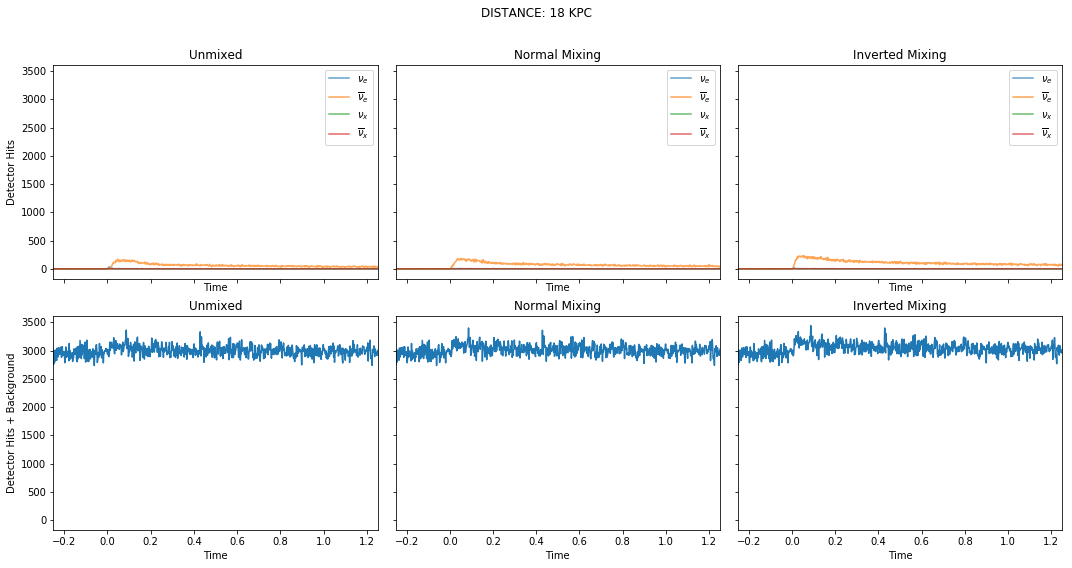

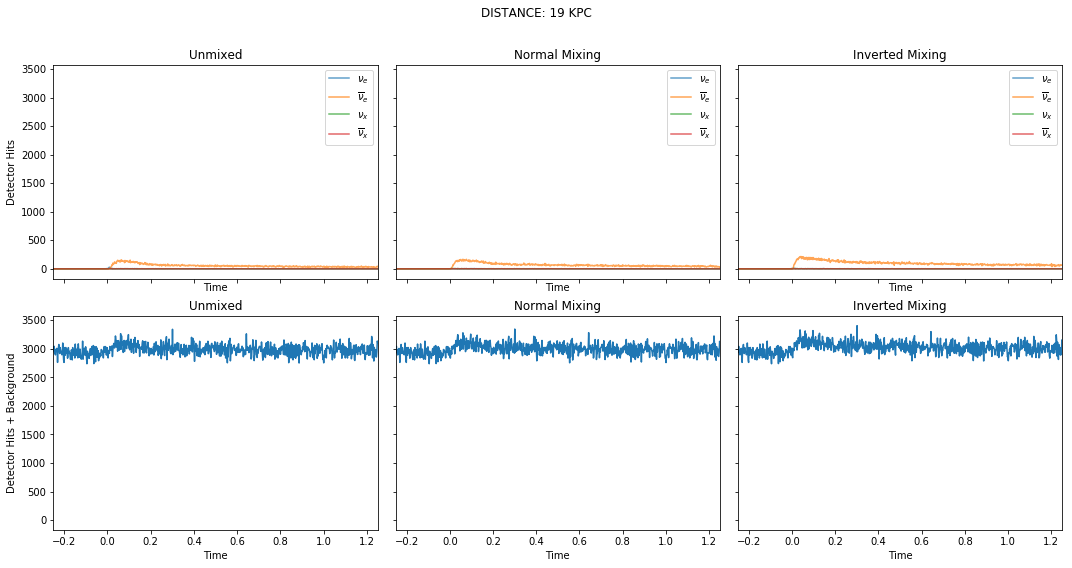

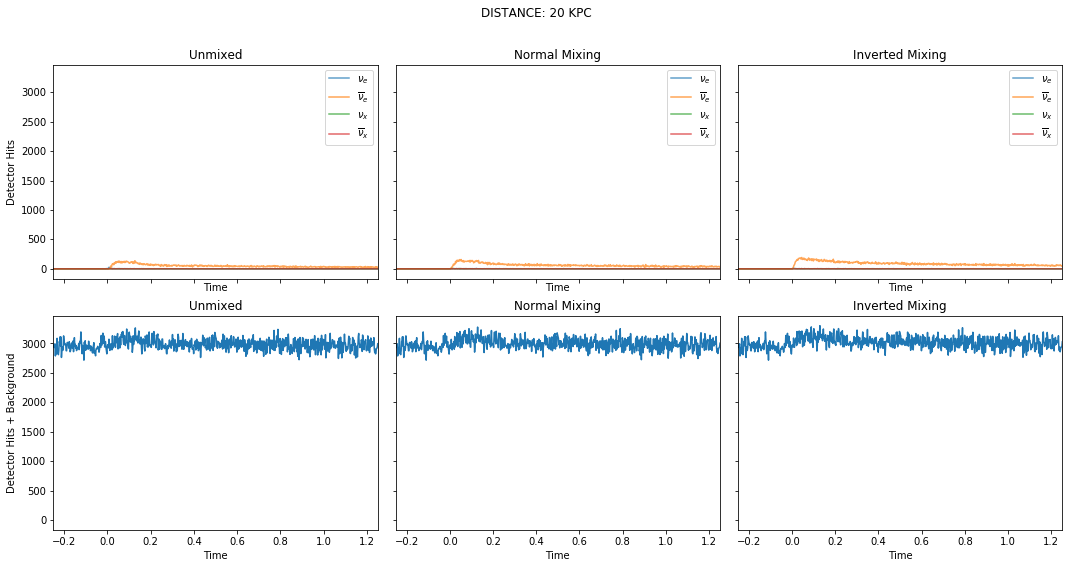

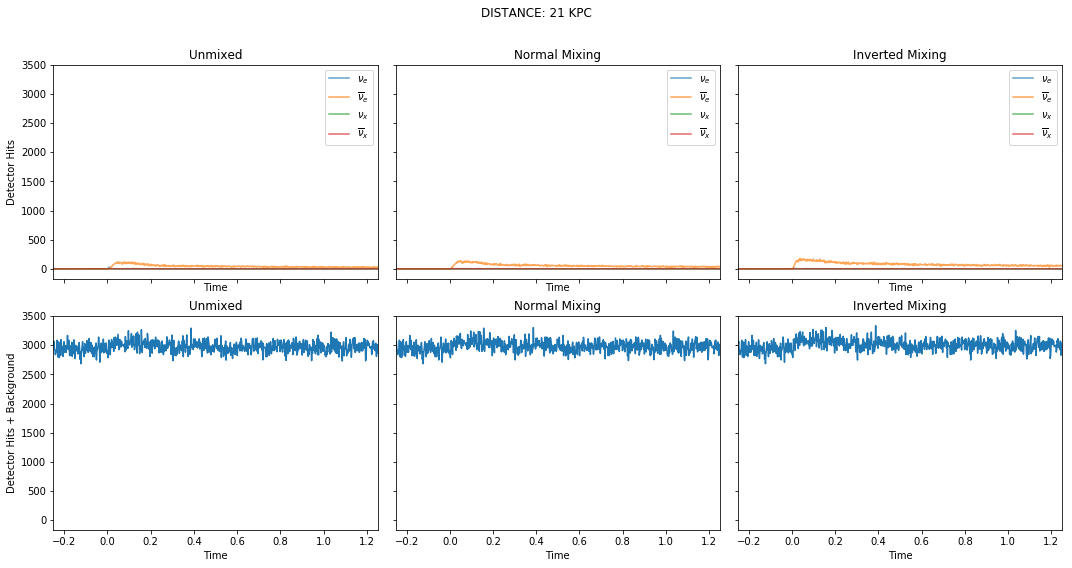

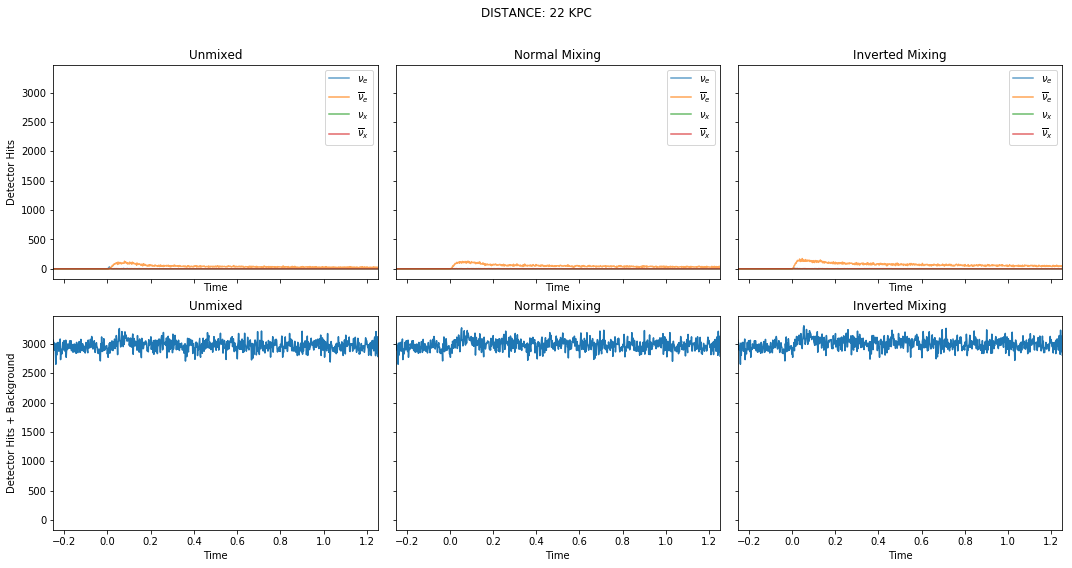

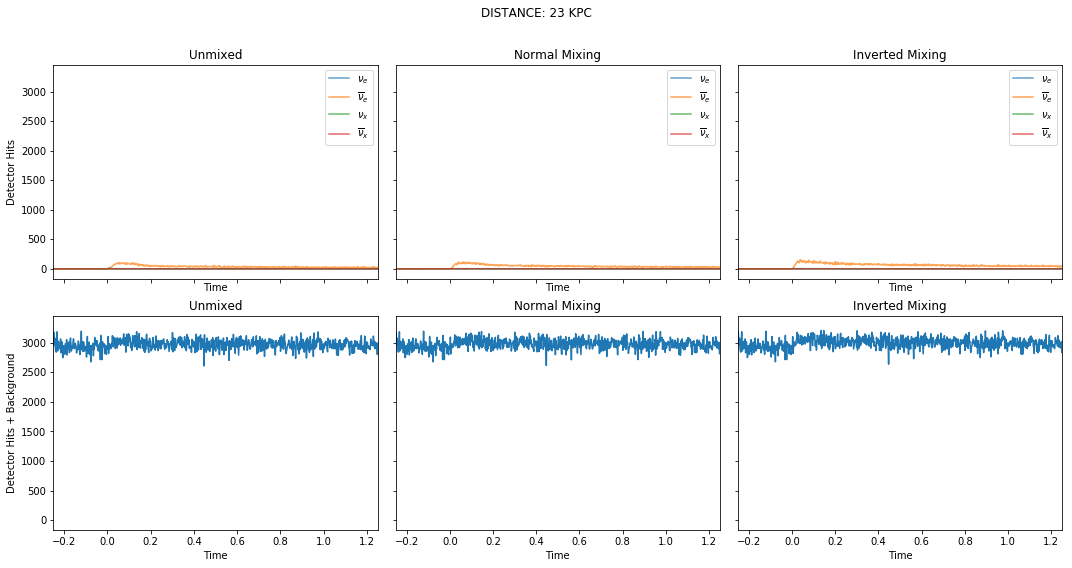

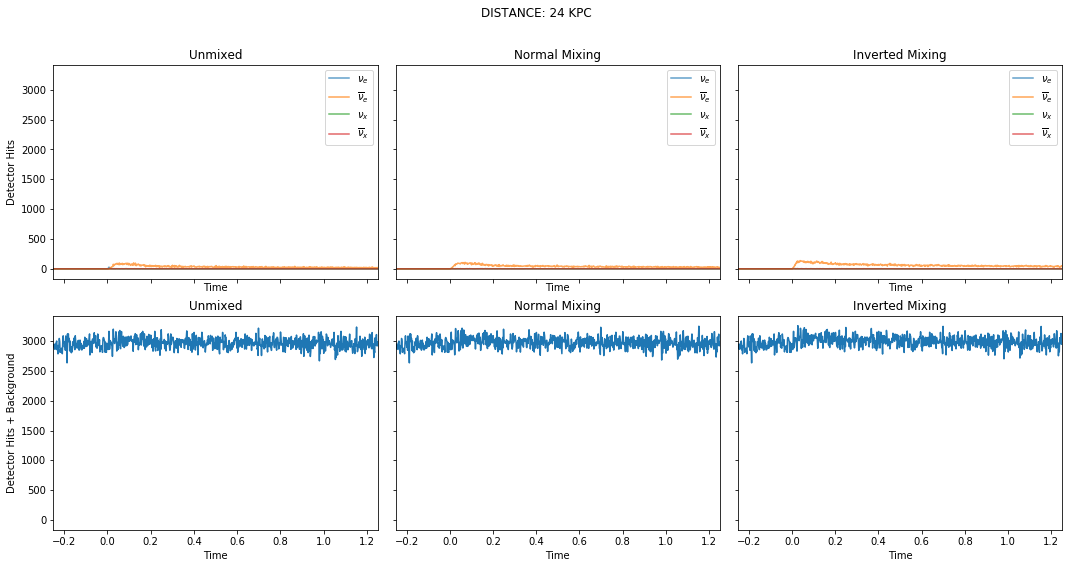

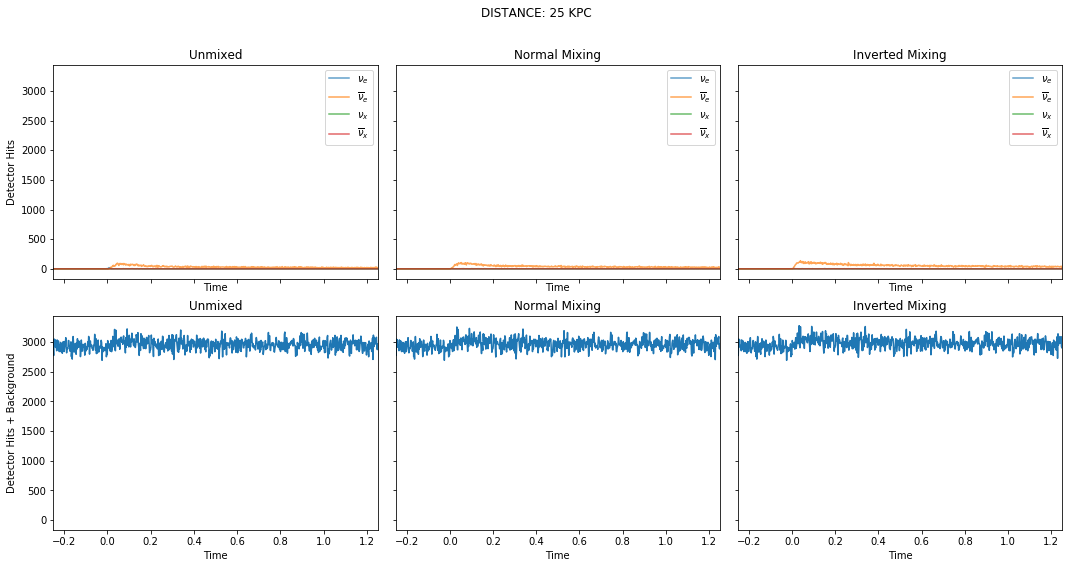

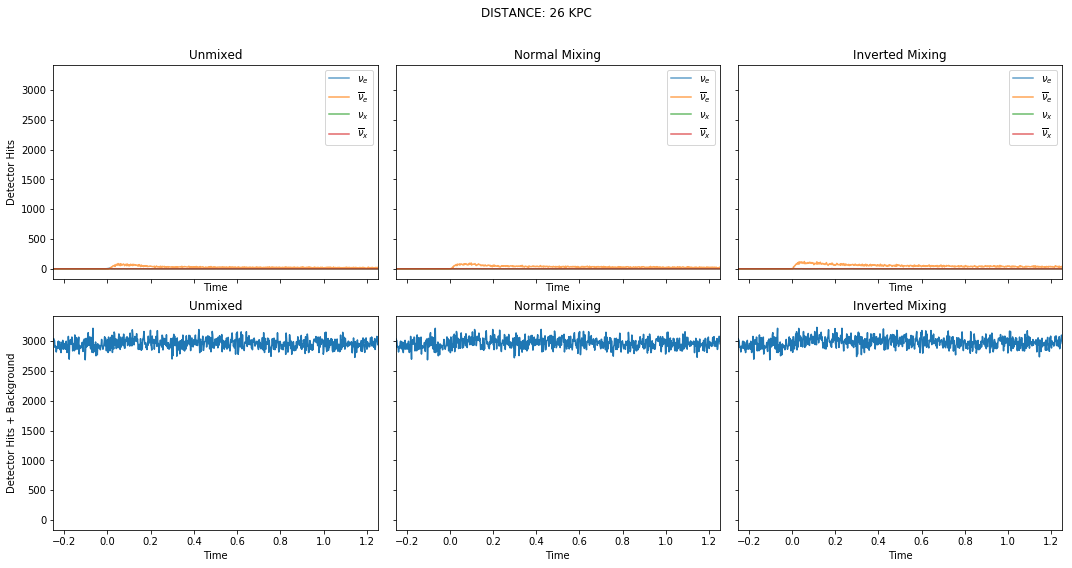

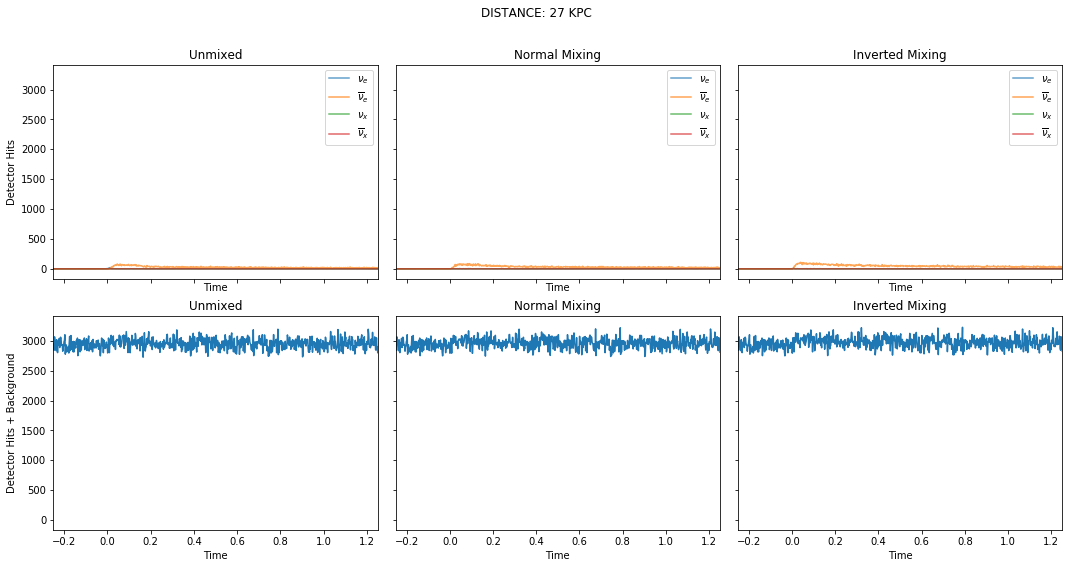

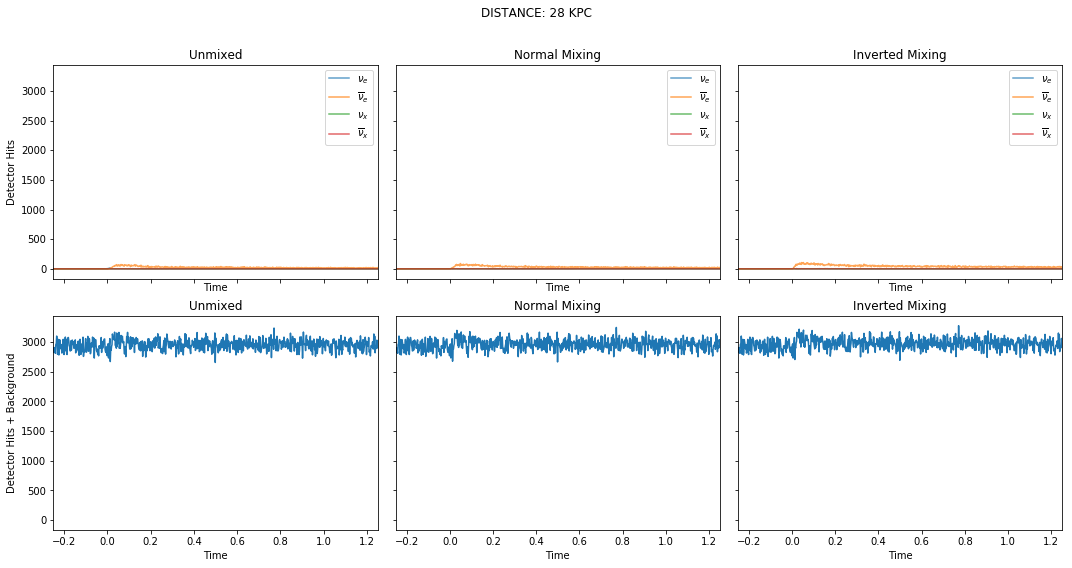

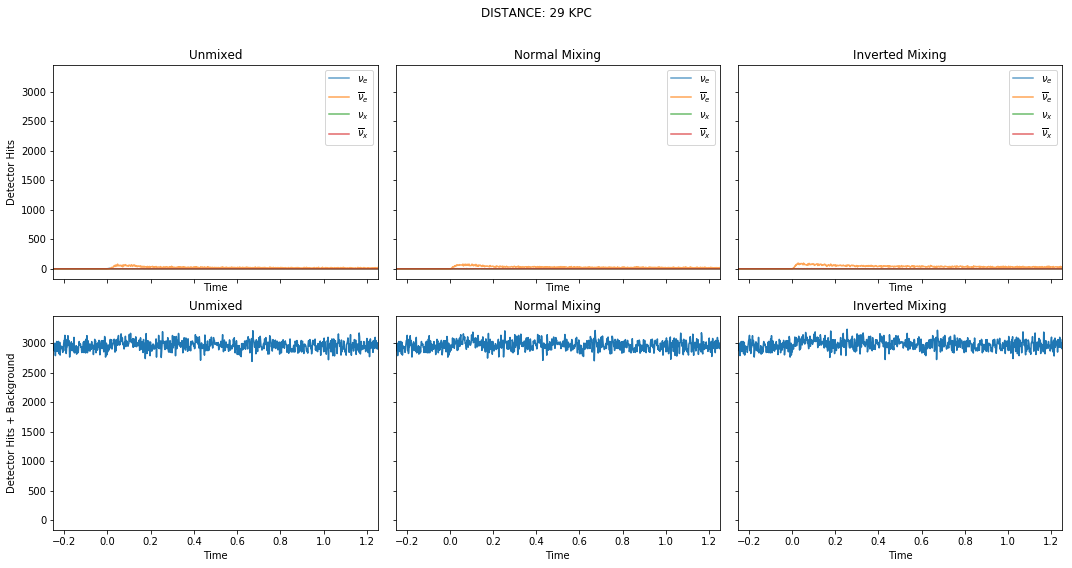

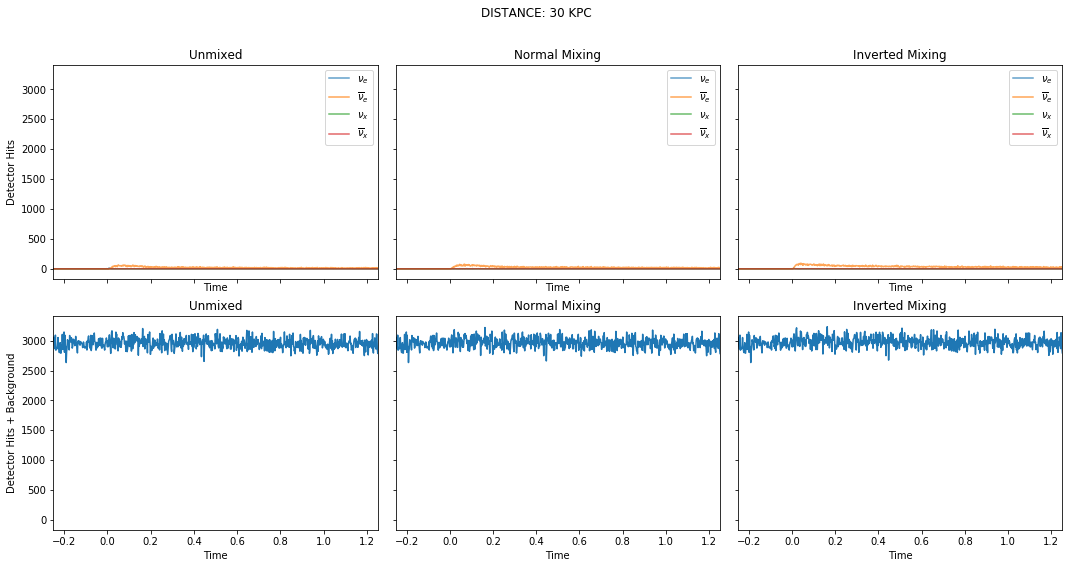

In [9]:
for d in range(1, 31):
    new_hits = hits(sig, d)
    hits_n = hits(sig_norm, d)
    hits_i = hits(sig_inv, d)
    
    fig, axes = plt.subplots(2, 3, figsize=(15, 8), sharex = True, sharey = True)
    ax1, ax2 = axes
    fig.suptitle('DISTANCE: {0} KPC'.format(d))
    
    # Plotting Detector Hits for each flavor
    for nu, flavor in enumerate(Flavor):
        astrTime, astrSignal = rebin(time, new_hits[nu], dt, icecube_dt)
        ax1[0].plot(astrTime, astrSignal, label = flavor.to_tex(), alpha = 0.7)
        
    ax1[0].set(xlim=(-0.25, 1.25),
           xlabel = 'Time',
           ylabel = 'Detector Hits',
           title = 'Unmixed')
    ax1[0].legend()
    
    for nu, flavor in enumerate(Flavor):
        astrTime, astrSignal = rebin(time, hits_n[nu], dt, icecube_dt)
        ax1[1].plot(astrTime, astrSignal, label = flavor.to_tex(), alpha = 0.7)
    ax1[1].set(xlabel = 'Time', title = 'Normal Mixing')
    ax1[1].legend()

    for nu, flavor in enumerate(Flavor):
        astrTime, astrSignal = rebin(time, hits_i[nu], dt, icecube_dt)
        ax1[2].plot(astrTime, astrSignal, label = flavor.to_tex(), alpha = 0.7)
    ax1[2].set(xlabel = 'Time', title = 'Inverted Mixing')
    ax1[2].legend()
    
    # Plotting total detector hits + background
    astrTime, astrSignal = rebin(time, sum(new_hits), dt, icecube_dt)
    bg = np.random.normal(dr, dr_er, len(astrSignal))
    
    ax2[0].plot(astrTime, astrSignal + bg)
    ax2[0].set(title ='Unmixed',
            xlabel = 'Time',
            ylabel = 'Detector Hits + Background')

    astrTime, astrSignal = rebin(time, sum(hits_n), dt, icecube_dt)
    ax2[1].plot(astrTime, astrSignal + bg)
    ax2[1].set(title = 'Normal Mixing', xlabel = 'Time')

    astrTime, astrSignal = rebin(time, sum(hits_i), dt, icecube_dt)
    ax2[2].plot(astrTime, astrSignal + bg)
    ax2[2].set(title = 'Inverted Mixing', xlabel = 'Time')


    fig.tight_layout()
    fig.subplots_adjust(top = 0.88)
    
#     outfile = '%s.jpeg' % (d)
    

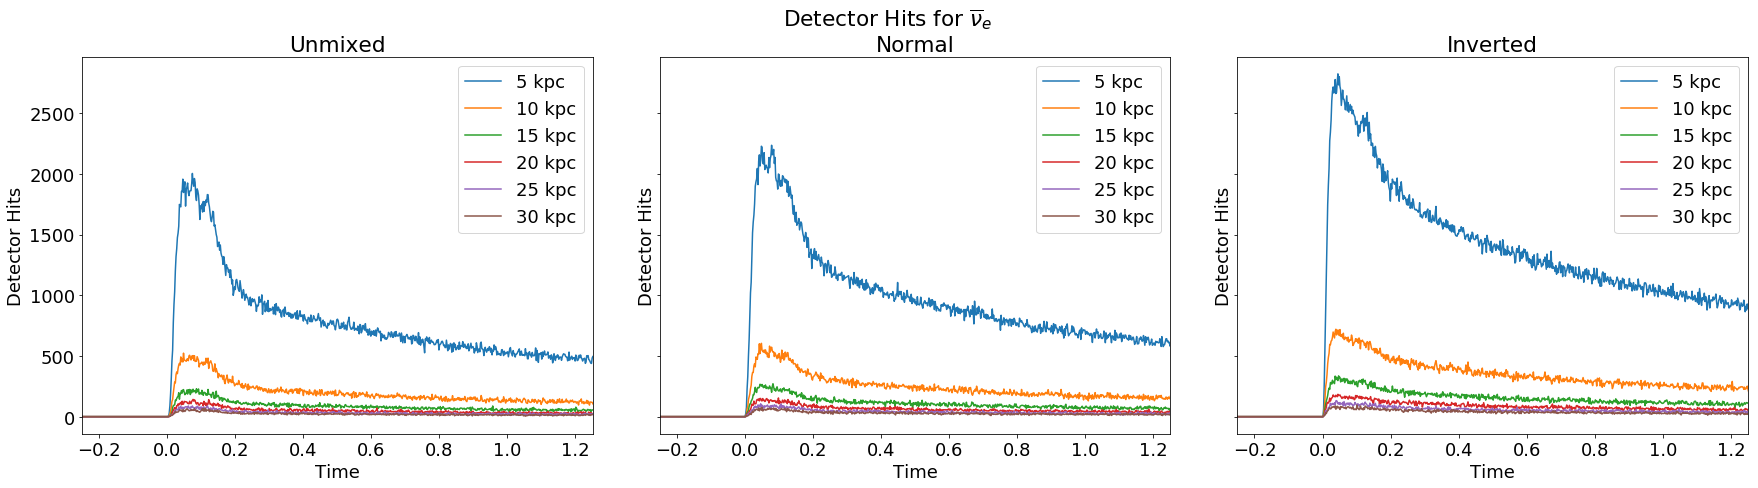

In [33]:
## Plotting nu_e_bar hits for each oscillation scenario
fig, axes = plt.subplots(1, 3, figsize = (25, 7), sharex = True, sharey = True)
ax1, ax2, ax3 = axes
fig.suptitle(r'Detector Hits for $\overline{\nu}_e$')
for d in range(5, 31, 5):
    new_hits = hits(sig, d)
    hits_n = hits(sig_norm, d)
    hits_i = hits(sig_inv, d)
    
    astrTime1, astrSignal1 = rebin(time, new_hits[1], dt, icecube_dt)
    astrTime2, astrSignal2 = rebin(time, hits_n[1], dt, icecube_dt)
    astrTime3, astrSignal3 = rebin(time, hits_i[1], dt, icecube_dt)
    
    ax1.plot(astrTime1, astrSignal1, label = '{0} kpc'.format(d))
    ax1.set(xlim = (-0.25, 1.25),
           xlabel = 'Time',
           ylabel = 'Detector Hits',
           title = 'Unmixed')
    ax1.legend()
    
    ax2.plot(astrTime2, astrSignal2, label = '{0} kpc'.format(d))
    ax2.set(xlim = (-0.25, 1.25),
           xlabel = 'Time',
           ylabel = 'Detector Hits',
           title = 'Normal')
    ax2.legend()
    
    ax3.plot(astrTime3, astrSignal3, label = '{0} kpc'.format(d))
    ax3.set(xlim = (-0.25, 1.25),
           xlabel = 'Time',
           ylabel = 'Detector Hits',
           title = 'Inverted')
    ax3.legend()
    
fig.tight_layout()
fig.subplots_adjust(top = 0.88)
